In [1]:
# import torch
# import torch.nn as nn
# import torchvision.models as models
# import torch.nn.functional as F

# import torch
# import torch.nn as nn
# import numpy as np
# import xarray as xr
# import json

# from torch.utils.data import DataLoader
# from tqdm.auto import tqdm

# def create_sequences(data, time_steps=12):
#     sequences = []
#     for i in range(len(data) - time_steps):
#         sequences.append(data[i:(i + time_steps)])
#     return torch.FloatTensor(np.array(sequences))

# # Load and preprocess data
# ds = xr.open_dataset('gistemp1200_GHCNv4_ERSSTv5.nc') 
# data = ds['tempanomaly'].fillna(0).values  # [time, lat, lon]
# data = (data - data.mean()) / data.std()  # Normalize

# # Reshape to [samples, time_steps, channels, height, width]
# sequences = create_sequences(data).unsqueeze(2)  # Add channel dim


# # New model using pretrained ResNet18 and TransformerEncoder
# class ClimateNet(nn.Module):
#     def __init__(self, time_steps=11, hidden_dim=512):
#         super().__init__()
#         self.time_steps = time_steps

#         # Load pretrained ResNet18 and remove the classifier head
#         resnet = models.resnet18(pretrained=True)
#         self.feature_extractor = nn.Sequential(*list(resnet.children())[:-2])  # Output: [B, 512, H/32, W/32]

#         # Optional: freeze earlier layers
#         for param in list(self.feature_extractor.parameters())[:6]:
#             param.requires_grad = False

#         self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 8))  # Downsample to fixed size
#         self.flatten = nn.Flatten(start_dim=1)  # [B, 512*4*8]

#         # Positional Embedding + Transformer Encoder for temporal modeling
#         self.temporal_input_dim = 512 * 4 * 8
#         self.positional_encoding = nn.Parameter(torch.randn(time_steps, self.temporal_input_dim))
#         encoder_layer = nn.TransformerEncoderLayer(d_model=self.temporal_input_dim, nhead=8)
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

#         # Decoder: map temporal encoding to predicted map
#         self.decoder = nn.Sequential(
#             nn.Linear(self.temporal_input_dim, 512),
#             nn.ReLU(),
#             nn.Linear(512, 90 * 180),
#             nn.Unflatten(1, (90, 180))
#         )

#     def forward(self, x):
#         # x: [B, T=11, C=1, H=90, W=180]

#         B, T, C, H, W = x.shape
#         features = []

#         for t in range(T):
#             frame = x[:, t]  # [B, 1, 90, 180]
#             rgb_input = frame.repeat(1, 3, 1, 1)  # ResNet expects 3-channel input
#             feat = self.feature_extractor(rgb_input)  # [B, 512, H', W']
#             feat = self.adaptive_pool(feat)  # [B, 512, 4, 8]
#             feat = self.flatten(feat)  # [B, 512*4*8]
#             features.append(feat)

#         features = torch.stack(features, dim=1)  # [B, T, F]
#         features += self.positional_encoding.unsqueeze(0)  # Add positional info
#         features = features.transpose(0, 1)  # [T, B, F] for transformer
#         encoded = self.transformer(features)  # [T, B, F]
#         encoded_final = encoded[-1]  # Last timestep embedding

#         return self.decoder(encoded_final)  # Output: [B, 90, 180]


# def evaluate_model(model, test_loader, criterion):
#     model.eval()
#     test_loss = 0
#     test_acc = 0
#     all_outputs = []
#     all_targets = []
    
#     with torch.no_grad():
#         for batch in test_loader:
#             inputs = batch[:, :-1]
#             targets = batch[:, -1, 0]
            
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             test_loss += loss.item()
            
#             # Accuracy calculation
#             batch_acc = ((outputs - targets).abs() < 0.2).float().mean().item()
#             test_acc += batch_acc
            
#             # Save predictions and targets for analysis
#             all_outputs.append(outputs.cpu())
#             all_targets.append(targets.cpu())
    
#     avg_test_loss = test_loss / len(test_loader)
#     avg_test_acc = test_acc / len(test_loader)
    
#     return avg_test_loss, avg_test_acc, torch.cat(all_outputs), torch.cat(all_targets)

# # Training loop with evaluation and logging
# epoch_results = []  # To store results for each epoch

# # 3. Training Setup
# model = ClimateNet()
# # Before training
# # model = ClimateNetV2()

# criterion = nn.L1Loss()  # MAE loss as in [1][4]
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# # 4. Train/Test Split
# split = int(0.8 * len(sequences))
# train_data = sequences[:split]
# test_data = sequences[split:]

# # Modified data loading
# train_loader = DataLoader(train_data, batch_size=32, 
#                         shuffle=True, drop_last=True)

# import torch.nn.functional as F

# # Combine MAE with spatial gradient loss
# def gradient_loss(pred, target):
#     dy_pred, dx_pred = torch.gradient(pred, dim=[-2,-1])
#     dy_true, dx_true = torch.gradient(target, dim=[-2,-1])
#     return F.l1_loss(dy_pred, dy_true) + F.l1_loss(dx_pred, dx_true)

# # Add spectral loss for spatial coherence
# def spectral_loss(pred, target):
#     pred_fft = torch.fft.fft2(pred)
#     target_fft = torch.fft.fft2(target)
#     return F.mse_loss(pred_fft.real, target_fft.real)

# # Modified training loop
# for epoch in range(10):
#     epoch_loss = 0
#     epoch_acc = 0
#     progress_bar = tqdm(DataLoader(train_data, batch_size=16, shuffle=True),
#                         desc=f"Epoch {epoch+1}/50",
#                         leave=False)
    
#     for batch in progress_bar:
#         inputs = batch[:, :-1]
#         targets = batch[:, -1, 0]
        
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = 0.7 * F.l1_loss(outputs, targets) + 0.3 * gradient_loss(outputs, targets)
#         bias_penalty = torch.mean(outputs - targets)
#         loss += 0.1 * bias_penalty.abs()
#         loss.backward()
#         optimizer.step()
        
#         epoch_loss += loss.item()
#         batch_acc = ((outputs - targets).abs() < 0.2).float().mean().item()
#         epoch_acc += batch_acc
#         progress_bar.set_postfix({'Loss': f"{loss.item():.4f}", 'Acc': f"{batch_acc:.2%}"})
    
#     avg_train_loss = epoch_loss / len(progress_bar)
#     avg_train_acc = epoch_acc / len(progress_bar)
    
#     # Evaluation phase
#     avg_test_loss, avg_test_acc, test_outputs, test_targets = evaluate_model(model, DataLoader(test_data, batch_size=16), criterion)
    
#     # Save sample predictions from test data for this epoch
#     sample_indices = np.random.choice(len(test_data), size=5, replace=False)  # Select random samples
#     sample_inputs = torch.stack([test_data[idx][:-1] for idx in sample_indices])
#     sample_targets = torch.stack([test_data[idx][-1, 0] for idx in sample_indices])
    
#     with torch.no_grad():
#         sample_predictions = model(sample_inputs).cpu()

#     # Log results for this epoch
#     epoch_results.append({
#         'epoch': epoch + 1,
#         'train_loss': avg_train_loss,
#         'train_accuracy': avg_train_acc,
#         'test_loss': avg_test_loss,
#         'test_accuracy': avg_test_acc,
#         'sample_predictions': sample_predictions.numpy().tolist(),
#         'sample_targets': sample_targets.numpy().tolist(),
#         'sample_indices': sample_indices.tolist(),
#     })
    
#     print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.2%}, "
#           f"Test Loss: {avg_test_loss:.4f}, Test Acc: {avg_test_acc:.2%}")

# # During preprocessing
# data_mean = data.mean()
# data_std = data.std()
# np.savez('normalization.npz', mean=data_mean, std=data_std)

# with open('training_results.json', 'w') as f:
#     json.dump(epoch_results, f)

# torch.save({
#     'epoch': 50,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'loss': criterion,
# }, 'climate_model_v1.pth')

# import matplotlib.pyplot as plt

# def plot_sample(model, dataset, num_samples=3):
#     model.eval()
#     indices = np.random.choice(len(dataset), num_samples)
    
#     with torch.no_grad():
#         fig, axs = plt.subplots(num_samples, 4, figsize=(15, 5*num_samples))
#         for i, idx in enumerate(indices):
#             input_data = dataset[idx][:-1].unsqueeze(0)
#             target = dataset[idx][-1, 0]
            
#             # Prediction
#             prediction = model(input_data).squeeze()

#             # Get single frame (adjust timestep as needed)
#             input_frame = dataset[idx][10].squeeze()  # Shape becomes [90, 180]
            
#             # Plotting
#             axs[i,0].imshow(input_frame.numpy(), cmap='coolwarm')
#             axs[i,0].set_title('Input Sequence')
#             axs[i,1].imshow(target.numpy(), cmap='coolwarm')
#             axs[i,1].set_title('Ground Truth')
#             axs[i,2].imshow(prediction.numpy(), cmap='coolwarm')
#             axs[i,2].set_title('Prediction')
#             # axs[i,2].imshow((target - prediction).numpy(), cmap='bwr', vmin=-1, vmax=1)
#             # axs[i,2].set_title('Difference')
#             # Add difference maps and error histograms
#             axs[i,3].hist((target - prediction).flatten().numpy(), bins=50)
#             axs[i,3].set_title('Error Distribution')
            
#         plt.tight_layout()
#         plt.show()

# # Usage (after training)
# plot_sample(model, test_data)



In [2]:
# import torch
# import torch.nn as nn
# import torchvision.models as models
# import torch.nn.functional as F


# import torch
# import torch.nn as nn
# import numpy as np
# import xarray as xr
# import json

# from torch.utils.data import DataLoader
# from tqdm.auto import tqdm

# def create_sequences(data, time_steps=12):
#     sequences = []
#     for i in range(len(data) - time_steps):
#         sequences.append(data[i:(i + time_steps)])
#     return torch.FloatTensor(np.array(sequences))

# # Load and preprocess data
# ds = xr.open_dataset('gistemp1200_GHCNv4_ERSSTv5.nc') 
# data = ds['tempanomaly'].fillna(0).values  # [time, lat, lon]
# data = (data - data.mean()) / data.std()  # Normalize

# # Reshape to [samples, time_steps, channels, height, width]
# sequences = create_sequences(data).unsqueeze(2)  # Add channel dim


# # New model using pretrained ResNet18 and TransformerEncoder
# class ClimateNet(nn.Module):
#     def __init__(self, time_steps=11, hidden_dim=512):
#         super().__init__()
#         self.time_steps = time_steps

#         # Load pretrained ResNet18 and remove the classifier head
#         resnet = models.resnet18(pretrained=True)
#         self.feature_extractor = nn.Sequential(*list(resnet.children())[:-2])  # Output: [B, 512, H/32, W/32]

#         # Optional: freeze earlier layers
#         for param in list(self.feature_extractor.parameters())[:6]:
#             param.requires_grad = False

#         # self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 8))  # Downsample to fixed size
#         self.pool = nn.AvgPool2d(kernel_size=(2, 2))
#         self.flatten = nn.Flatten(start_dim=1)  # [B, 512*4*8]

#         # Positional Embedding + Transformer Encoder for temporal modeling
#         self.temporal_input_dim = 512 * 4 * 8
#         self.positional_encoding = nn.Parameter(torch.randn(time_steps, self.temporal_input_dim))
#         encoder_layer = nn.TransformerEncoderLayer(d_model=self.temporal_input_dim, nhead=8)
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

#         # Decoder: map temporal encoding to predicted map
#         self.decoder = nn.Sequential(
#             nn.Linear(self.temporal_input_dim, 512),
#             nn.ReLU(),
#             nn.Linear(512, 90 * 180),
#             nn.Unflatten(1, (90, 180))
#         )

#     def forward(self, x):
#         # x: [B, T=11, C=1, H=90, W=180]

#         B, T, C, H, W = x.shape
#         features = []

#         for t in range(T):
#             frame = x[:, t]  # [B, 1, 90, 180]
#             rgb_input = frame.repeat(1, 3, 1, 1)  # ResNet expects 3-channel input
#             feat = self.feature_extractor(rgb_input)  # [B, 512, H', W']
#             # feat = self.adaptive_pool(feat)  # [B, 512, 4, 8]
#             feat = self.pool(feat)
#             feat = self.flatten(feat)  # [B, 512*4*8]
#             features.append(feat)

#         features = torch.stack(features, dim=1)  # [B, T, F]
#         features += self.positional_encoding.unsqueeze(0)  # Add positional info
#         features = features.transpose(0, 1)  # [T, B, F] for transformer
#         encoded = self.transformer(features)  # [T, B, F]
#         encoded_final = encoded[-1]  # Last timestep embedding

#         return self.decoder(encoded_final)  # Output: [B, 90, 180]


# def evaluate_model(model, test_loader, criterion):
#     model.eval()
#     test_loss = 0
#     test_acc = 0
#     all_outputs = []
#     all_targets = []
    
#     with torch.no_grad():
#         for batch in test_loader:
#             inputs = batch[:, :-1]
#             targets = batch[:, -1, 0]
            
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             test_loss += loss.item()
            
#             # Accuracy calculation
#             batch_acc = ((outputs - targets).abs() < 0.2).float().mean().item()
#             test_acc += batch_acc
            
#             # Save predictions and targets for analysis
#             all_outputs.append(outputs.cpu())
#             all_targets.append(targets.cpu())
    
#     avg_test_loss = test_loss / len(test_loader)
#     avg_test_acc = test_acc / len(test_loader)
    
#     return avg_test_loss, avg_test_acc, torch.cat(all_outputs), torch.cat(all_targets)

# # Training loop with evaluation and logging
# epoch_results = []  # To store results for each epoch

# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# # 3. Training Setup
# model = ClimateNet().to(device)
# # Before training
# # model = ClimateNetV2()

# criterion = nn.L1Loss()  # MAE loss as in [1][4]
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# # 4. Train/Test Split
# split = int(0.8 * len(sequences))
# train_data = sequences[:split]
# test_data = sequences[split:]

# # Modified data loading
# train_loader = DataLoader(train_data, batch_size=32, 
#                         shuffle=True, drop_last=True)

# import torch.nn.functional as F

# # Combine MAE with spatial gradient loss
# def gradient_loss(pred, target):
#     dy_pred, dx_pred = torch.gradient(pred, dim=[-2,-1])
#     dy_true, dx_true = torch.gradient(target, dim=[-2,-1])
#     return F.l1_loss(dy_pred, dy_true) + F.l1_loss(dx_pred, dx_true)

# # Add spectral loss for spatial coherence
# def spectral_loss(pred, target):
#     pred_fft = torch.fft.fft2(pred)
#     target_fft = torch.fft.fft2(target)
#     return F.mse_loss(pred_fft.real, target_fft.real)

# # Modified training loop
# for epoch in range(10):
#     epoch_loss = 0
#     epoch_acc = 0
#     progress_bar = tqdm(DataLoader(train_data, batch_size=16, shuffle=True),
#                         desc=f"Epoch {epoch+1}/50",
#                         leave=False)
    
#     for batch in progress_bar:
#         inputs = batch[:, :-1].to(device)
#         targets = batch[:, -1, 0].to(device)
        
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = 0.7 * F.l1_loss(outputs, targets) + 0.3 * gradient_loss(outputs, targets)
#         bias_penalty = torch.mean(outputs - targets)
#         loss += 0.1 * bias_penalty.abs()
#         loss.backward()
#         optimizer.step()
        
#         epoch_loss += loss.item()
#         batch_acc = ((outputs - targets).abs() < 0.2).float().mean().item()
#         epoch_acc += batch_acc
#         progress_bar.set_postfix({'Loss': f"{loss.item():.4f}", 'Acc': f"{batch_acc:.2%}"})
    
#     avg_train_loss = epoch_loss / len(progress_bar)
#     avg_train_acc = epoch_acc / len(progress_bar)
    
#     # Evaluation phase
#     avg_test_loss, avg_test_acc, test_outputs, test_targets = evaluate_model(model, DataLoader(test_data, batch_size=16), criterion)
    
#     # Save sample predictions from test data for this epoch
#     sample_indices = np.random.choice(len(test_data), size=5, replace=False)  # Select random samples
#     sample_inputs = torch.stack([test_data[idx][:-1] for idx in sample_indices]).to(device)
#     sample_targets = torch.stack([test_data[idx][-1, 0] for idx in sample_indices]).to(device)
    
#     with torch.no_grad():
#         sample_predictions = model(sample_inputs).cpu()

#     # Log results for this epoch
#     epoch_results.append({
#         'epoch': epoch + 1,
#         'train_loss': avg_train_loss,
#         'train_accuracy': avg_train_acc,
#         'test_loss': avg_test_loss,
#         'test_accuracy': avg_test_acc,
#         'sample_predictions': sample_predictions.numpy().tolist(),
#         'sample_targets': sample_targets.numpy().tolist(),
#         'sample_indices': sample_indices.tolist(),
#     })
    
#     print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.2%}, "
#           f"Test Loss: {avg_test_loss:.4f}, Test Acc: {avg_test_acc:.2%}")

# # During preprocessing
# data_mean = data.mean()
# data_std = data.std()
# np.savez('normalization.npz', mean=data_mean, std=data_std)

# with open('training_results.json', 'w') as f:
#     json.dump(epoch_results, f)

# torch.save({
#     'epoch': 50,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'loss': criterion,
# }, 'climate_model_v1.pth')

# import matplotlib.pyplot as plt

# def plot_sample(model, dataset, num_samples=3):
#     model.eval()
#     indices = np.random.choice(len(dataset), num_samples)
    
#     with torch.no_grad():
#         fig, axs = plt.subplots(num_samples, 4, figsize=(15, 5*num_samples))
#         for i, idx in enumerate(indices):
#             input_data = dataset[idx][:-1].unsqueeze(0)
#             target = dataset[idx][-1, 0]
            
#             # Prediction
#             prediction = model(input_data).squeeze()

#             # Get single frame (adjust timestep as needed)
#             input_frame = dataset[idx][10].squeeze()  # Shape becomes [90, 180]
            
#             # Plotting
#             axs[i,0].imshow(input_frame.numpy(), cmap='coolwarm')
#             axs[i,0].set_title('Input Sequence')
#             axs[i,1].imshow(target.numpy(), cmap='coolwarm')
#             axs[i,1].set_title('Ground Truth')
#             axs[i,2].imshow(prediction.numpy(), cmap='coolwarm')
#             axs[i,2].set_title('Prediction')
#             # axs[i,2].imshow((target - prediction).numpy(), cmap='bwr', vmin=-1, vmax=1)
#             # axs[i,2].set_title('Difference')
#             # Add difference maps and error histograms
#             axs[i,3].hist((target - prediction).flatten().numpy(), bins=50)
#             axs[i,3].set_title('Error Distribution')
            
#         plt.tight_layout()
#         plt.show()

# # Usage (after training)
# plot_sample(model, test_data)



Using device: mps


Epoch 1/10:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.4768 | Train Acc=0.4823 | Test Loss=0.5929 | Test Acc=0.4196


Epoch 2/10:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 2: Train Loss=0.4579 | Train Acc=0.5035 | Test Loss=0.6138 | Test Acc=0.4021


Epoch 3/10:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.4549 | Train Acc=0.5071 | Test Loss=0.5967 | Test Acc=0.4150


Epoch 4/10:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.4537 | Train Acc=0.5085 | Test Loss=0.5929 | Test Acc=0.4132


Epoch 5/10:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.4514 | Train Acc=0.5107 | Test Loss=0.5857 | Test Acc=0.4294


Epoch 6/10:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 6: Train Loss=0.4506 | Train Acc=0.5109 | Test Loss=0.5814 | Test Acc=0.4230


Epoch 7/10:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 7: Train Loss=0.4499 | Train Acc=0.5109 | Test Loss=0.5770 | Test Acc=0.4118


Epoch 8/10:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 8: Train Loss=0.4489 | Train Acc=0.5119 | Test Loss=0.5835 | Test Acc=0.4329


Epoch 9/10:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 9: Train Loss=0.4474 | Train Acc=0.5132 | Test Loss=0.5815 | Test Acc=0.4112


Epoch 10/10:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 10: Train Loss=0.4471 | Train Acc=0.5136 | Test Loss=0.5838 | Test Acc=0.4297


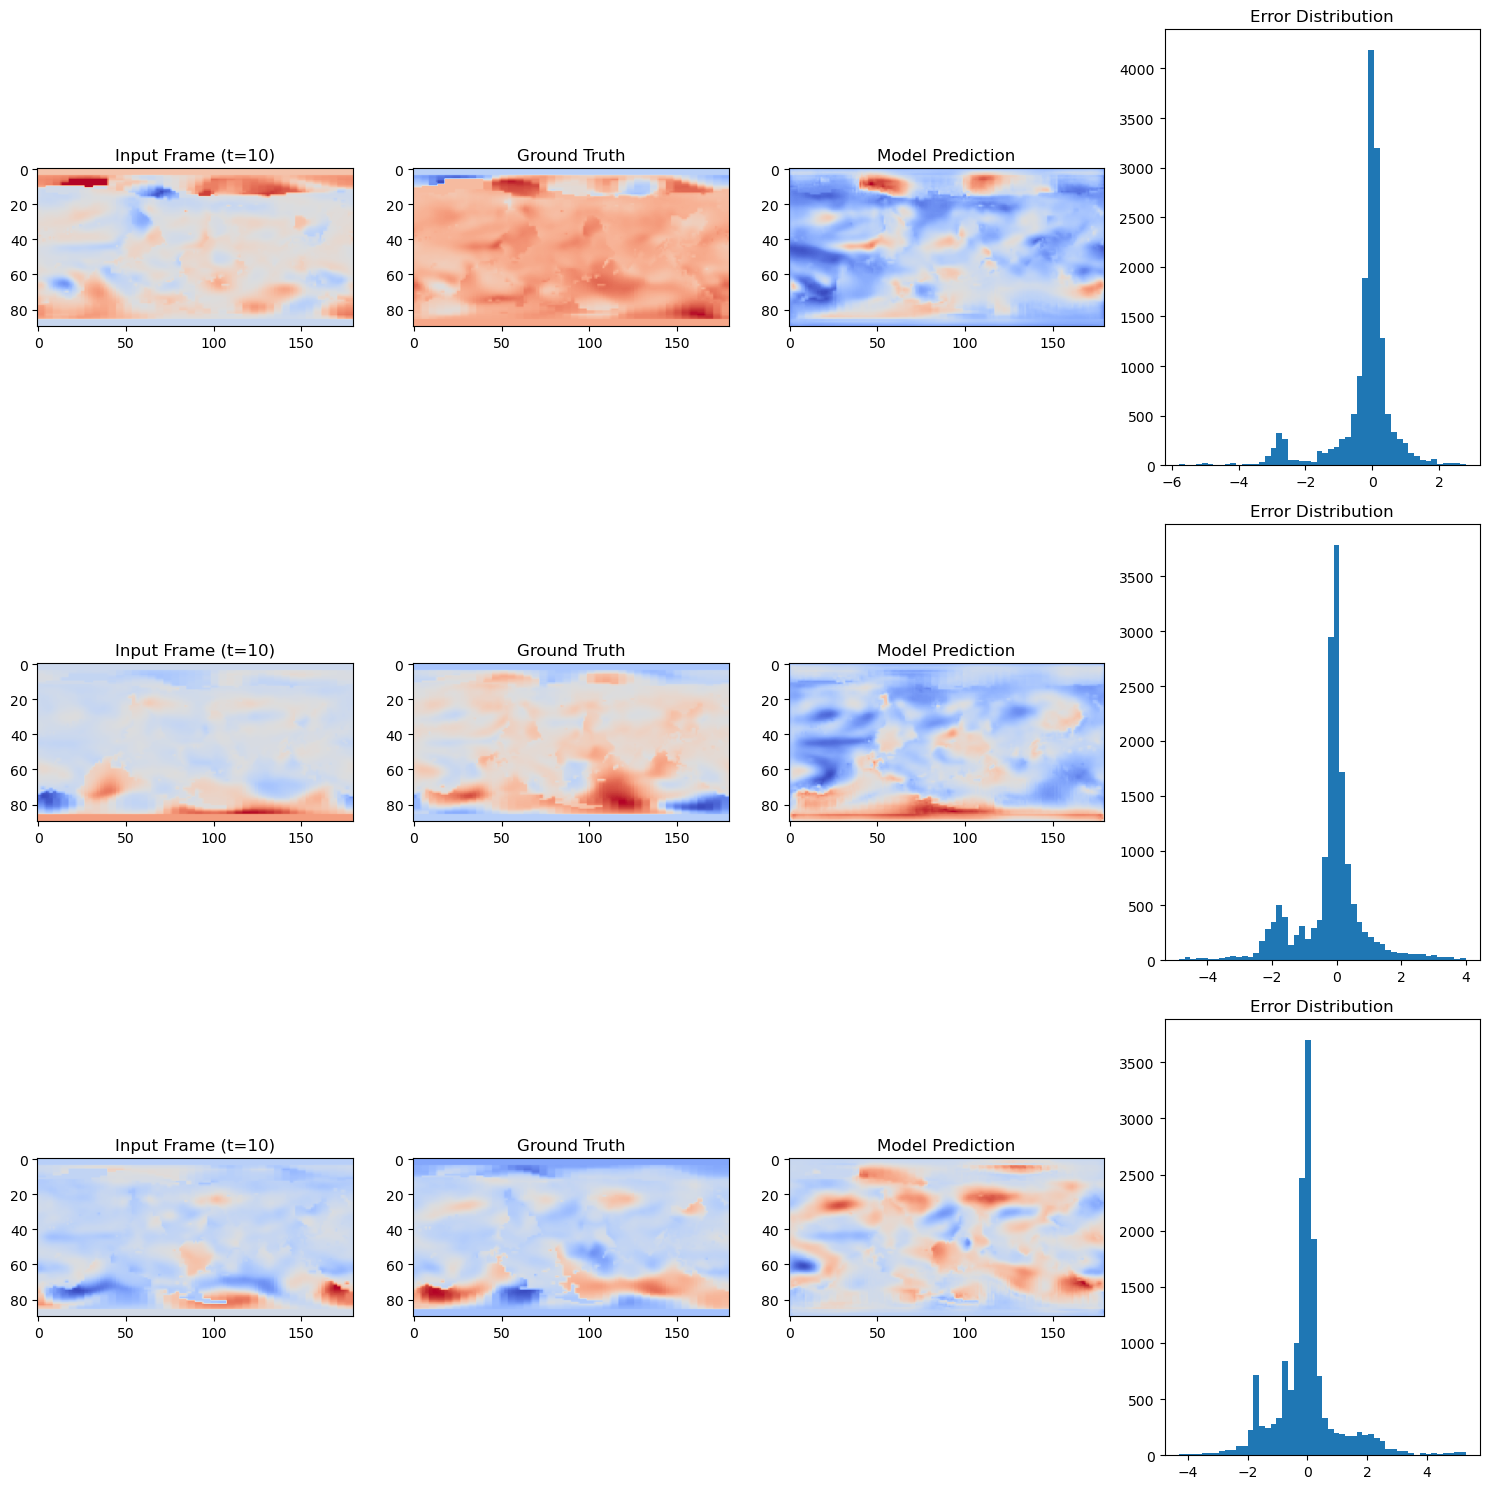

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import numpy as np
import xarray as xr
import torch.nn.functional as F  # Required for F.interpolate and other functional ops

# Set device: use Apple M1/M2/M3 GPU if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"\033[92mUsing device: {device}\033[0m")

# === Data loading and preprocessing ===
ds = xr.open_dataset('gistemp1200_GHCNv4_ERSSTv5.nc')
data = ds['tempanomaly'].fillna(0).values  # [time, lat, lon]

# Normalize globally
data = (data - data.mean()) / data.std()

# Create sequences: [samples, time_steps, C=1, H, W]
time_steps = 24
def create_sequences(data, time_steps=12):
    sequences = []
    for i in range(len(data) - time_steps):
        seq = data[i:(i + time_steps)]
        sequences.append(seq)
    return torch.FloatTensor(np.array(sequences))

sequences = create_sequences(data, time_steps).unsqueeze(2)  # Add channel dimension

# Split into train/test
train_size = int(len(sequences) * 0.8)
train_data = sequences[:train_size]
test_data = sequences[train_size:]

# Dataset & Dataloader
class ClimateDataset(torch.utils.data.Dataset):
    def __init__(self, sequences, augment=False):
        self.sequences = sequences
        self.augment = augment
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = self.sequences[idx].clone()  # [T, C, H, W]
        
        if self.augment and torch.rand(1).item() > 0.5:
            if torch.rand(1).item() > 0.5:
                seq = torch.flip(seq, dims=[-1])  # Horizontal flip
            seq += torch.randn_like(seq) * 0.03  # Add noise
            
        return seq

train_dataset = ClimateDataset(train_data, augment=True)
test_dataset = ClimateDataset(test_data, augment=False)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# === Model, Loss, Optimizer ===
class EnhancedConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        padding = kernel_size // 2
        
        self.conv = nn.Conv2d(
            in_channels=input_dim + hidden_dim,
            out_channels=4 * hidden_dim,  # For gates: i, f, o, g
            kernel_size=kernel_size,
            padding=padding
        )
        
        # Initialize weights
        self.conv.weight.data.normal_(0, 0.01)
        self.conv.bias.data.zero_()
        
    def forward(self, x, h_prev, c_prev):
        # Concatenate input and previous hidden state
        combined = torch.cat([x, h_prev], dim=1)
        
        # Convolution
        gates = self.conv(combined)
        
        # Split gates
        ingate, forgetgate, outgate, cellgate = torch.split(gates, self.hidden_dim, dim=1)
        
        # Apply activations
        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        outgate = torch.sigmoid(outgate)
        cellgate = torch.tanh(cellgate)
        
        # Update cell state
        c_next = forgetgate * c_prev + ingate * cellgate
        
        # Update hidden state
        h_next = outgate * torch.tanh(c_next)
        
        return h_next, c_next

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)

class ImprovedClimateNet(nn.Module):
    def __init__(self, in_channels=1, hidden_dims=[32, 64, 128]):
        super().__init__()
        
        # Spatial feature extraction - U-Net inspired
        self.encoder1 = DoubleConv(in_channels, hidden_dims[0])
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = DoubleConv(hidden_dims[0], hidden_dims[1])
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = DoubleConv(hidden_dims[1], hidden_dims[2])
        
        # Spatial bottleneck with residual connection
        self.bottleneck = nn.Sequential(
            nn.Conv2d(hidden_dims[2], hidden_dims[2], kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dims[2]),
            nn.LeakyReLU(0.2),
            nn.Conv2d(hidden_dims[2], hidden_dims[2], kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dims[2]),
            nn.LeakyReLU(0.2)
        )
        
        # ConvLSTM for spatio-temporal modeling
        self.convlstm = EnhancedConvLSTMCell(
            input_dim=hidden_dims[2],
            hidden_dim=hidden_dims[2],
            kernel_size=3
        )
        
        # Use adaptive upsampling to handle any size discrepancies
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_up2 = nn.Conv2d(hidden_dims[2], hidden_dims[1], kernel_size=1)
        
        self.decoder2 = DoubleConv(hidden_dims[1] * 2, hidden_dims[1])
        
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_up1 = nn.Conv2d(hidden_dims[1], hidden_dims[0], kernel_size=1)
        
        self.decoder1 = DoubleConv(hidden_dims[0] * 2, hidden_dims[0])
        
        # Output projection
        self.output_conv = nn.Conv2d(hidden_dims[0], 1, kernel_size=1)
        
        # Self-attention for global context
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dims[2], num_heads=4, batch_first=True
        )
        
        # Apply dropout for regularization
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # x shape: [batch_size, time_steps, channels, height, width]
        B, T, C, H, W = x.shape
        
        # Calculate downsampled dimensions for the LSTM
        # We need to process one frame to get the actual dimensions
        with torch.no_grad():
            test_frame = x[0, 0].unsqueeze(0)  # [1, C, H, W]
            e1_test = self.encoder1(test_frame)
            p1_test = self.pool1(e1_test)
            e2_test = self.encoder2(p1_test)
            p2_test = self.pool2(e2_test)
            e3_test = self.encoder3(p2_test)
            
            # Get exact dimensions for hidden states
            _, _, h_dim, w_dim = e3_test.shape
        
        # Initialize ConvLSTM states with the correct dimensions
        h_t = torch.zeros(B, 128, h_dim, w_dim).to(x.device)
        c_t = torch.zeros(B, 128, h_dim, w_dim).to(x.device)
        
        # Spatial feature maps for skip connections
        encoder1_features = []
        encoder2_features = []
        
        # Process sequence through time
        for t in range(T):
            # Current frame
            x_t = x[:, t]  # [B, C, H, W]
            
            # Encoder path
            e1 = self.encoder1(x_t)
            encoder1_features.append(e1)
            p1 = self.pool1(e1)
            
            e2 = self.encoder2(p1)
            encoder2_features.append(e2)
            p2 = self.pool2(e2)
            
            e3 = self.encoder3(p2)
            
            # Bottleneck with residual connection
            bottleneck = self.bottleneck(e3) + e3
            
            # Update ConvLSTM state
            h_t, c_t = self.convlstm(bottleneck, h_t, c_t)
        
        # Apply attention to final hidden state for global context
        # Reshape for attention: [B, H*W, C]
        h_flat = h_t.flatten(2).transpose(1, 2)
        h_attn, _ = self.attention(h_flat, h_flat, h_flat)
        
        # Reshape back to spatial format
        h_attn = h_attn.transpose(1, 2).reshape(B, 128, h_dim, w_dim)
        
        # Add residual connection to attention output
        h_final = h_attn + h_t
        
        # Apply dropout
        h_final = self.dropout(h_final)
        
        # Decoder path with skip connections from the last timestep
        up2 = self.upsample2(h_final)
        up2 = self.conv_up2(up2)
        
        # Ensure the dimensions match before concatenation
        if up2.shape[2:] != encoder2_features[-1].shape[2:]:
            up2 = F.interpolate(up2, size=encoder2_features[-1].shape[2:], 
                               mode='bilinear', align_corners=True)
            
        d2 = torch.cat([up2, encoder2_features[-1]], dim=1)
        d2 = self.decoder2(d2)
        
        up1 = self.upsample1(d2)
        up1 = self.conv_up1(up1)
        
        # Ensure the dimensions match before concatenation
        if up1.shape[2:] != encoder1_features[-1].shape[2:]:
            up1 = F.interpolate(up1, size=encoder1_features[-1].shape[2:], 
                               mode='bilinear', align_corners=True)
            
        d1 = torch.cat([up1, encoder1_features[-1]], dim=1)
        d1 = self.decoder1(d1)
        
        # Final prediction
        output = self.output_conv(d1)
        
        return output.squeeze(1)  # [B, H, W]


model = ImprovedClimateNet().to(device)
criterion = nn.L1Loss()  # MAE
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# === Evaluation Function ===
def evaluate_model(model, dataloader, criterion):
    model.eval()
    test_loss = 0
    test_acc = 0
    all_outputs = []
    all_targets = []
    
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch[:, :-1].to(device)           # [B, T-1, C, H, W]
            targets = batch[:, -1, 0].to(device)        # [B, H, W]
            
            outputs = model(inputs)                     # [B, H, W]
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            
            acc = ((outputs - targets).abs() < 0.2).float().mean().item()
            test_acc += acc
            
            all_outputs.append(outputs.cpu())
            all_targets.append(targets.cpu())
    
    return (test_loss / len(dataloader),
            test_acc / len(dataloader),
            torch.cat(all_outputs),
            torch.cat(all_targets))

import matplotlib.pyplot as plt

# === Sample Visualization Function ===
def plot_sample(model, dataset, num_samples=3):
    model.eval()
    indices = np.random.choice(len(dataset), num_samples)
    
    with torch.no_grad():
        fig, axs = plt.subplots(num_samples, 4, figsize=(15, 5*num_samples))
        for i, idx in enumerate(indices):
            input_data = dataset[idx][:-1].unsqueeze(0).to(device)  # Move to device
            target = dataset[idx][-1, 0].cpu()  # [H, W]
            
            # Model prediction
            prediction = model(input_data).squeeze().cpu()  # Move back to CPU

            # Get one middle frame from the sequence to visualize as input
            input_frame = dataset[idx][10].squeeze().cpu()  # [H, W]
            
            # Plot input
            axs[i, 0].imshow(input_frame.numpy(), cmap='coolwarm')
            axs[i, 0].set_title('Input Frame (t=10)')
            
            # Ground truth
            axs[i, 1].imshow(target.numpy(), cmap='coolwarm')
            axs[i, 1].set_title('Ground Truth')
            
            # Prediction
            axs[i, 2].imshow(prediction.numpy(), cmap='coolwarm')
            axs[i, 2].set_title('Model Prediction')
            
            # Error distribution
            axs[i, 3].hist((target - prediction).flatten().numpy(), bins=50)
            axs[i, 3].set_title('Error Distribution')
        
        plt.tight_layout()
        plt.show()

# === Updated Training Loop with Train Accuracy ===
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_acc = 0
    
    loop = tqdm(train_loader, desc=f"\033[96mEpoch {epoch+1}/{num_epochs}\033[0m")
    for batch in loop:
        inputs = batch[:, :-1].to(device)               # [B, T-1, C, H, W]
        targets = batch[:, -1, 0].to(device)            # [B, H, W]
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        # Accumulate loss and accuracy
        train_loss += loss.item()
        acc = ((outputs - targets).abs() < 0.2).float().mean().item()
        train_acc += acc
        
        loop.set_postfix(loss=loss.item(), acc=acc)

    # Compute average loss and accuracy
    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = train_acc / len(train_loader)

    # Evaluate on test set
    test_loss, test_acc, _, _ = evaluate_model(model, test_loader, criterion)

    print(f"\033[93mEpoch {epoch+1}: "
          f"Train Loss={avg_train_loss:.4f} | Train Acc={avg_train_acc:.4f} | "
          f"Test Loss={test_loss:.4f} | Test Acc={test_acc:.4f}\033[0m")

# === Visualize Predictions After Training ===
plot_sample(model, test_dataset)


# model_path = "improved_climatenet.pth"
# torch.save(model.state_dict(), model_path)

# print(f"\033[92mModel saved to {model_path}\033[0m")

# model = ImprovedClimateNet().to(device)
# model.load_state_dict(torch.load("improved_climatenet.pth", map_location=device))
# model.eval()

# print(f"\033[92mModel loaded from {model_path}\033[0m")